First import the modules we need:

In [1]:
import trajectory, trajectory.post, trajectory.aero, csv
import numpy as np

To run an aerodynamic simulation, we must have already run a trajectory simulation and saved the output to a .JSON. We will now import that JSON:

In [2]:
imported_data = trajectory.from_json("output.json")

We need to recreate the Rocket object that was used to generate output.json. This is because output.json only contains trajectory data, but no details on the actual launch vehicle. The only actual part that's used for the heating analysis is the LaunchSite, but I've put in everything anyway.

In [3]:
'''Import motor data - copied from Joe Hunt's simulation'''
with open('novus_sim_6.1/motor_out.csv') as csvfile:
    motor_out = csv.reader(csvfile)

    (motor_time_data, prop_mass_data, cham_pres_data,
     throat_data, gamma_data, nozzle_efficiency_data,
     exit_pres_data, area_ratio_data, vmass_data, lden_data, lmass_data, fuel_mass_data) = [], [], [], [], [], [], [], [], [], [], [], []

    next(motor_out)
    for row in motor_out:
        motor_time_data.append(float(row[0]))
        prop_mass_data.append(float(row[1]))
        cham_pres_data.append(float(row[2]))
        throat_data.append(float(row[3]))
        gamma_data.append(float(row[4]))
        nozzle_efficiency_data.append(float(row[5]))
        exit_pres_data.append(float(row[6]))
        area_ratio_data.append(float(row[7]))
        vmass_data.append(float(row[8]))
        lden_data.append(float(row[9]))
        lmass_data.append(float(row[10]))
        fuel_mass_data.append(float(row[11]))
        
        #This is a bit inefficient given that these are constants, (we only need to record them once):
        DENSITY_FUEL = float(row[12])
        DIA_FUEL = float(row[13])
        LENGTH_PORT = float(row[14])

'''Rocket parameters'''
dry_mass = 60                               # kg
rocket_length = 6.529                       # m
rocket_radius = 98.5e-3                     # m
rocket_wall_thickness = 1e-2                # m - This is just needed for the mass model
pos_tank_bottom = 4.456                     # m - Distance between the nose tip and the bottom of the nitrous tank
pos_solidfuel_bottom = 4.856+LENGTH_PORT    # m - Distance between the nose tip and bottom of the solid fuel grain 
ref_area = 0.0305128422                     # m^2 - Reference area for aerodynamic coefficients

'''Set up aerodynamic properties'''
#Get approximate values for the rotational damping coefficients
c_damp_pitch = trajectory.aero.pitch_damping_coefficient(rocket_length, rocket_radius, fin_number = 4, area_per_fin = 0.07369928)
c_damp_roll = 0

#Import drag coefficients from RASAero II
aerodynamic_coefficients = trajectory.aero.RASAeroData("data/Martlet4RasAeroII.CSV", ref_area, c_damp_pitch, c_damp_roll)

'''Set up the mass model'''
liquid_fuel = trajectory.LiquidFuel(lden_data, lmass_data, rocket_radius, pos_tank_bottom, motor_time_data)
solid_fuel = trajectory.SolidFuel(fuel_mass_data, DENSITY_FUEL, DIA_FUEL/2, LENGTH_PORT, pos_solidfuel_bottom, motor_time_data)
dry_mass_model = trajectory.HollowCylinder(rocket_radius, rocket_radius - rocket_wall_thickness, rocket_length, dry_mass)

mass_model = trajectory.HybridMassModel(rocket_length, solid_fuel, liquid_fuel, vmass_data, 
                                        dry_mass_model.mass, dry_mass_model.ixx(), dry_mass_model.iyy(), dry_mass_model.izz(), 
                                        dry_cog = rocket_length/2)

'''Create the other objects needed to initialise the Rocket object'''
pulsar = trajectory.Motor(motor_time_data, 
                          prop_mass_data, 
                          cham_pres_data, 
                          throat_data, 
                          gamma_data, 
                          nozzle_efficiency_data, 
                          exit_pres_data, 
                          area_ratio_data)

launch_site = trajectory.LaunchSite(rail_length=10, 
                                    rail_yaw=0, 
                                    rail_pitch=0, 
                                    alt=0, 
                                    longi=0, 
                                    lat=0, 
                                    wind=[4.94975,4.94975,0])

parachute = trajectory.Parachute(main_s = 13.9,
                                 main_c_d = 0.78,
                                 drogue_s = 1.13,
                                 drogue_c_d = 0.78,
                                 main_alt = 1000,
                                 attatch_distance = 0)

"""Create the Rocket object"""
martlet4 = trajectory.Rocket(mass_model, pulsar, aerodynamic_coefficients, launch_site, h=0.05, variable=True, alt_poll_interval=1, parachute=parachute)


Now we can start actually setting up an aerodynamic heating simulation. First we must define the nosecone shape, by creating a TangentOgive object:

In [4]:
tangent_ogive = trajectory.post.TangentOgive(xprime = 73.7e-2, yprime = (19.7e-2)/2)

'xprime' is the length of the nosecone, and 'yprime' is the radius. See Fig 2. of https://arc.aiaa.org/doi/pdf/10.2514/3.62081 for a diagram.

We can now set up the aerodynamic heating simulation, and run a step:

In [5]:
analysis = trajectory.post.HeatTransfer(tangent_ogive, imported_data, martlet4)
analysis.step()

Subsonic flow, skipping step number 0


In [6]:
analysis.run(iterations = 300)

Subsonic flow, skipping step number 1
Subsonic flow, skipping step number 2
Subsonic flow, skipping step number 3
Subsonic flow, skipping step number 4
Subsonic flow, skipping step number 5
Subsonic flow, skipping step number 6
Subsonic flow, skipping step number 7
Subsonic flow, skipping step number 8
Subsonic flow, skipping step number 9
Subsonic flow, skipping step number 10
Subsonic flow, skipping step number 11
Subsonic flow, skipping step number 12
Subsonic flow, skipping step number 13
Subsonic flow, skipping step number 14
Subsonic flow, skipping step number 15
Subsonic flow, skipping step number 16
Subsonic flow, skipping step number 17
Subsonic flow, skipping step number 18
Subsonic flow, skipping step number 19
Subsonic flow, skipping step number 20
Subsonic flow, skipping step number 21
Subsonic flow, skipping step number 22
Subsonic flow, skipping step number 23
Subsonic flow, skipping step number 24
Subsonic flow, skipping step number 25
Subsonic flow, skipping step numbe

 D:\Anaconda3\lib\site-packages\thermo\viscosity.py:826: RuntimeWarning:invalid value encountered in double_scalars


i=100 station=1 q_lam=0.00 W/m^2 q_turb=-463810.78 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=2 q_lam=238.86 W/m^2 q_turb=-380745.95 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=3 q_lam=451.01 W/m^2 q_turb=-333563.22 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=4 q_lam=638.36 W/m^2 q_turb=-299318.52 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=5 q_lam=797.38 W/m^2 q_turb=-271851.45 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=6 q_lam=927.35 W/m^2 q_turb=-248602.30 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=7 q_lam=1028.93 W/m^2 q_turb=-228271.93 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=8 q_lam=1103.57 W/m^2 q_turb=-210115.37 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=9 q_lam=1153.20 W/m^2 q_turb=-193668.18 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=10 q_lam=1180.06 W/m^2 q_turb=-178622.27 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=11 q_lam=1592.13 W/m^2 q_turb=-238855.73 W/m^2 alt=1371.62 m t=8.10 s
i=100 station=12 q_lam=1813.73 W/m^2 q_turb=-259404.79 W/m^2 alt=1371.62 m t=8.10 s
i=100 sta

i=126 station=7 q_lam=3056.35 W/m^2 q_turb=-185422.90 W/m^2 alt=4378.27 m t=14.74 s
i=126 station=8 q_lam=3335.40 W/m^2 q_turb=-166005.73 W/m^2 alt=4378.27 m t=14.74 s
i=126 station=9 q_lam=3548.42 W/m^2 q_turb=-148653.07 W/m^2 alt=4378.27 m t=14.74 s
i=126 station=10 q_lam=3699.89 W/m^2 q_turb=-133037.16 W/m^2 alt=4378.27 m t=14.74 s
i=126 station=11 q_lam=4210.79 W/m^2 q_turb=-158800.50 W/m^2 alt=4378.27 m t=14.74 s
i=126 station=12 q_lam=4570.74 W/m^2 q_turb=-169650.04 W/m^2 alt=4378.27 m t=14.74 s
i=126 station=13 q_lam=4855.80 W/m^2 q_turb=-173562.36 W/m^2 alt=4378.27 m t=14.74 s
i=126 station=14 q_lam=5097.28 W/m^2 q_turb=-174243.29 W/m^2 alt=4378.27 m t=14.74 s
i=126 station=15 q_lam=5328.65 W/m^2 q_turb=-175032.10 W/m^2 alt=4378.27 m t=14.74 s
i=127 station=1 q_lam=0.00 W/m^2 q_turb=-416740.86 W/m^2 alt=4547.21 m t=15.04 s
i=127 station=2 q_lam=661.83 W/m^2 q_turb=-338059.84 W/m^2 alt=4547.21 m t=15.04 s
i=127 station=3 q_lam=1277.17 W/m^2 q_turb=-289771.13 W/m^2 alt=4547.21 m 

i=133 station=1 q_lam=0.00 W/m^2 q_turb=-357791.43 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=2 q_lam=739.36 W/m^2 q_turb=-286927.10 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=3 q_lam=1426.69 W/m^2 q_turb=-242988.23 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=4 q_lam=2060.28 W/m^2 q_turb=-210014.67 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=5 q_lam=2620.77 W/m^2 q_turb=-183261.14 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=6 q_lam=3101.42 W/m^2 q_turb=-160661.08 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=7 q_lam=3501.28 W/m^2 q_turb=-141119.15 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=8 q_lam=3822.58 W/m^2 q_turb=-123977.86 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=9 q_lam=4069.52 W/m^2 q_turb=-108806.11 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=10 q_lam=4247.50 W/m^2 q_turb=-95301.62 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=11 q_lam=4824.29 W/m^2 q_turb=-117996.35 W/m^2 alt=5390.14 m t=16.45 s
i=133 station=12 q_lam=5239.81 W/m^2 q_turb=-127932.85 W/m^2 alt=5390.14 m t=16

i=139 station=11 q_lam=4850.74 W/m^2 q_turb=-115883.18 W/m^2 alt=5446.62 m t=16.54 s
i=139 station=12 q_lam=5268.06 W/m^2 q_turb=-125715.33 W/m^2 alt=5446.62 m t=16.54 s
i=139 station=13 q_lam=5603.32 W/m^2 q_turb=-129519.06 W/m^2 alt=5446.62 m t=16.54 s
i=139 station=14 q_lam=5889.89 W/m^2 q_turb=-130464.85 W/m^2 alt=5446.62 m t=16.54 s
i=139 station=15 q_lam=6164.50 W/m^2 q_turb=-131484.92 W/m^2 alt=5446.62 m t=16.54 s
i=140 station=1 q_lam=0.00 W/m^2 q_turb=-353804.97 W/m^2 alt=5448.30 m t=16.54 s
i=140 station=2 q_lam=743.09 W/m^2 q_turb=-283531.14 W/m^2 alt=5448.30 m t=16.54 s
i=140 station=3 q_lam=1433.97 W/m^2 q_turb=-239933.68 W/m^2 alt=5448.30 m t=16.54 s
i=140 station=4 q_lam=2070.90 W/m^2 q_turb=-207210.61 W/m^2 alt=5448.30 m t=16.54 s
i=140 station=5 q_lam=2634.40 W/m^2 q_turb=-180661.80 W/m^2 alt=5448.30 m t=16.54 s
i=140 station=6 q_lam=3117.68 W/m^2 q_turb=-158239.37 W/m^2 alt=5448.30 m t=16.54 s
i=140 station=7 q_lam=3519.79 W/m^2 q_turb=-138857.29 W/m^2 alt=5448.30 m t

i=146 station=4 q_lam=2058.94 W/m^2 q_turb=-206477.75 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=5 q_lam=2619.21 W/m^2 q_turb=-180043.24 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=6 q_lam=3099.74 W/m^2 q_turb=-157716.91 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=7 q_lam=3499.56 W/m^2 q_turb=-138417.26 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=8 q_lam=3820.93 W/m^2 q_turb=-121494.68 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=9 q_lam=4068.02 W/m^2 q_turb=-106522.97 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=10 q_lam=4246.26 W/m^2 q_turb=-93203.06 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=11 q_lam=4820.41 W/m^2 q_turb=-115454.79 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=12 q_lam=5234.73 W/m^2 q_turb=-125207.73 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=13 q_lam=5567.66 W/m^2 q_turb=-128976.91 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=14 q_lam=5852.29 W/m^2 q_turb=-129909.70 W/m^2 alt=5494.54 m t=16.62 s
i=146 station=15 q_lam=6125.03 W/m^2 q_turb=-130916.69 W/m^2 alt=5494.54

i=153 station=1 q_lam=0.00 W/m^2 q_turb=-339550.76 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=2 q_lam=700.73 W/m^2 q_turb=-272162.29 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=3 q_lam=1351.91 W/m^2 q_turb=-230366.40 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=4 q_lam=1951.98 W/m^2 q_turb=-199001.97 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=5 q_lam=2482.60 W/m^2 q_turb=-173559.61 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=6 q_lam=2937.41 W/m^2 q_turb=-152074.45 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=7 q_lam=3315.59 W/m^2 q_turb=-133504.48 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=8 q_lam=3619.33 W/m^2 q_turb=-117223.73 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=9 q_lam=3852.67 W/m^2 q_turb=-102821.41 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=10 q_lam=4020.79 W/m^2 q_turb=-90009.25 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=11 q_lam=4572.37 W/m^2 q_turb=-111845.26 W/m^2 alt=5865.21 m t=17.21 s
i=153 station=12 q_lam=4969.57 W/m^2 q_turb=-121423.15 W/m^2 alt=5865.21 m t=17

i=159 station=10 q_lam=3824.92 W/m^2 q_turb=-88344.52 W/m^2 alt=6195.44 m t=17.74 s
i=159 station=11 q_lam=4349.49 W/m^2 q_turb=-109373.60 W/m^2 alt=6195.44 m t=17.74 s
i=159 station=12 q_lam=4727.27 W/m^2 q_turb=-118575.90 W/m^2 alt=6195.44 m t=17.74 s
i=159 station=13 q_lam=5030.22 W/m^2 q_turb=-122126.25 W/m^2 alt=6195.44 m t=17.74 s
i=159 station=14 q_lam=5288.82 W/m^2 q_turb=-122999.84 W/m^2 alt=6195.44 m t=17.74 s
i=159 station=15 q_lam=5536.69 W/m^2 q_turb=-123943.55 W/m^2 alt=6195.44 m t=17.74 s
i=160 station=1 q_lam=0.00 W/m^2 q_turb=-328960.88 W/m^2 alt=6246.97 m t=17.82 s
i=160 station=2 q_lam=661.69 W/m^2 q_turb=-263881.45 W/m^2 alt=6246.97 m t=17.82 s
i=160 station=3 q_lam=1276.45 W/m^2 q_turb=-223546.50 W/m^2 alt=6246.97 m t=17.82 s
i=160 station=4 q_lam=1842.82 W/m^2 q_turb=-193287.56 W/m^2 alt=6246.97 m t=17.82 s
i=160 station=5 q_lam=2343.48 W/m^2 q_turb=-168743.36 W/m^2 alt=6246.97 m t=17.82 s
i=160 station=6 q_lam=2772.47 W/m^2 q_turb=-148014.46 W/m^2 alt=6246.97 m t

i=166 station=3 q_lam=1228.78 W/m^2 q_turb=-221063.70 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=4 q_lam=1773.74 W/m^2 q_turb=-191347.58 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=5 q_lam=2255.33 W/m^2 q_turb=-167243.33 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=6 q_lam=2667.83 W/m^2 q_turb=-146881.46 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=7 q_lam=3010.52 W/m^2 q_turb=-129271.72 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=8 q_lam=3285.44 W/m^2 q_turb=-113820.06 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=9 q_lam=3496.28 W/m^2 q_turb=-100137.30 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=10 q_lam=3647.79 W/m^2 q_turb=-87950.76 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=11 q_lam=4141.47 W/m^2 q_turb=-107844.95 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=12 q_lam=4497.62 W/m^2 q_turb=-116506.07 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=13 q_lam=4783.68 W/m^2 q_turb=-119809.56 W/m^2 alt=6510.51 m t=18.25 s
i=166 station=14 q_lam=5028.16 W/m^2 q_turb=-120579.41 W/m^2 alt=6510.51 

i=172 station=13 q_lam=4638.34 W/m^2 q_turb=-118569.49 W/m^2 alt=6680.16 m t=18.53 s
i=172 station=14 q_lam=4875.77 W/m^2 q_turb=-119325.87 W/m^2 alt=6680.16 m t=18.53 s
i=172 station=15 q_lam=5103.35 W/m^2 q_turb=-120152.59 W/m^2 alt=6680.16 m t=18.53 s
i=173 station=1 q_lam=0.00 W/m^2 q_turb=-319007.25 W/m^2 alt=6705.39 m t=18.57 s
i=173 station=2 q_lam=614.50 W/m^2 q_turb=-256270.41 W/m^2 alt=6705.39 m t=18.57 s
i=173 station=3 q_lam=1185.16 W/m^2 q_turb=-217437.16 W/m^2 alt=6705.39 m t=18.57 s
i=173 station=4 q_lam=1710.64 W/m^2 q_turb=-188319.01 W/m^2 alt=6705.39 m t=18.57 s
i=173 station=5 q_lam=2174.91 W/m^2 q_turb=-164700.58 W/m^2 alt=6705.39 m t=18.57 s
i=173 station=6 q_lam=2572.49 W/m^2 q_turb=-144747.61 W/m^2 alt=6705.39 m t=18.57 s
i=173 station=7 q_lam=2902.68 W/m^2 q_turb=-127488.81 W/m^2 alt=6705.39 m t=18.57 s
i=173 station=8 q_lam=3167.47 W/m^2 q_turb=-112341.72 W/m^2 alt=6705.39 m t=18.57 s
i=173 station=9 q_lam=3370.43 W/m^2 q_turb=-98924.94 W/m^2 alt=6705.39 m t=18

i=179 station=8 q_lam=2969.71 W/m^2 q_turb=-109951.88 W/m^2 alt=7019.89 m t=19.08 s
i=179 station=9 q_lam=3159.36 W/m^2 q_turb=-96965.16 W/m^2 alt=7019.89 m t=19.08 s
i=179 station=10 q_lam=3295.29 W/m^2 q_turb=-85388.42 W/m^2 alt=7019.89 m t=19.08 s
i=179 station=11 q_lam=3751.24 W/m^2 q_turb=-104786.86 W/m^2 alt=7019.89 m t=19.08 s
i=179 station=12 q_lam=4078.74 W/m^2 q_turb=-113215.10 W/m^2 alt=7019.89 m t=19.08 s
i=179 station=13 q_lam=4340.79 W/m^2 q_turb=-116426.30 W/m^2 alt=7019.89 m t=19.08 s
i=179 station=14 q_lam=4564.15 W/m^2 q_turb=-117173.79 W/m^2 alt=7019.89 m t=19.08 s
i=179 station=15 q_lam=4778.29 W/m^2 q_turb=-117989.69 W/m^2 alt=7019.89 m t=19.08 s
i=180 station=1 q_lam=0.00 W/m^2 q_turb=-310744.02 W/m^2 alt=7087.14 m t=19.19 s
i=180 station=2 q_lam=572.26 W/m^2 q_turb=-249974.83 W/m^2 alt=7087.14 m t=19.19 s
i=180 station=3 q_lam=1103.42 W/m^2 q_turb=-212405.68 W/m^2 alt=7087.14 m t=19.19 s
i=180 station=4 q_lam=1592.24 W/m^2 q_turb=-184248.65 W/m^2 alt=7087.14 m t=

i=186 station=1 q_lam=0.00 W/m^2 q_turb=-305031.03 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=2 q_lam=548.59 W/m^2 q_turb=-245520.33 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=3 q_lam=1057.67 W/m^2 q_turb=-208749.02 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=4 q_lam=1526.06 W/m^2 q_turb=-181196.09 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=5 q_lam=1939.53 W/m^2 q_turb=-158848.62 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=6 q_lam=2293.24 W/m^2 q_turb=-139962.43 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=7 q_lam=2586.63 W/m^2 q_turb=-123615.20 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=8 q_lam=2821.51 W/m^2 q_turb=-109254.72 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=9 q_lam=3001.12 W/m^2 q_turb=-96520.04 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=10 q_lam=3129.59 W/m^2 q_turb=-85158.88 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=11 q_lam=3561.69 W/m^2 q_turb=-103924.10 W/m^2 alt=7273.88 m t=19.50 s
i=186 station=12 q_lam=3871.91 W/m^2 q_turb=-112045.19 W/m^2 alt=7273.88 m t=19.

i=192 station=11 q_lam=3355.11 W/m^2 q_turb=-103006.93 W/m^2 alt=7540.73 m t=19.94 s
i=192 station=12 q_lam=3647.69 W/m^2 q_turb=-110874.25 W/m^2 alt=7540.73 m t=19.94 s
i=192 station=13 q_lam=3881.51 W/m^2 q_turb=-113827.93 W/m^2 alt=7540.73 m t=19.94 s
i=192 station=14 q_lam=4080.64 W/m^2 q_turb=-114467.70 W/m^2 alt=7540.73 m t=19.94 s
i=192 station=15 q_lam=4271.57 W/m^2 q_turb=-115176.29 W/m^2 alt=7540.73 m t=19.94 s
i=193 station=1 q_lam=0.00 W/m^2 q_turb=-296436.10 W/m^2 alt=7624.99 m t=20.08 s
i=193 station=2 q_lam=505.87 W/m^2 q_turb=-238970.51 W/m^2 alt=7624.99 m t=20.08 s
i=193 station=3 q_lam=975.16 W/m^2 q_turb=-203512.25 W/m^2 alt=7624.99 m t=20.08 s
i=193 station=4 q_lam=1406.78 W/m^2 q_turb=-176957.00 W/m^2 alt=7624.99 m t=20.08 s
i=193 station=5 q_lam=1787.63 W/m^2 q_turb=-155418.74 W/m^2 alt=7624.99 m t=20.08 s
i=193 station=6 q_lam=2113.25 W/m^2 q_turb=-137210.09 W/m^2 alt=7624.99 m t=20.08 s
i=193 station=7 q_lam=2383.15 W/m^2 q_turb=-121439.78 W/m^2 alt=7624.99 m t=

i=199 station=4 q_lam=1321.10 W/m^2 q_turb=-174276.48 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=5 q_lam=1678.26 W/m^2 q_turb=-153267.49 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=6 q_lam=1983.40 W/m^2 q_turb=-135502.20 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=7 q_lam=2236.07 W/m^2 q_turb=-120109.47 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=8 q_lam=2437.88 W/m^2 q_turb=-106568.94 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=9 q_lam=2591.69 W/m^2 q_turb=-94541.35 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=10 q_lam=2701.10 W/m^2 q_turb=-83790.33 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=11 q_lam=3080.96 W/m^2 q_turb=-101670.47 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=12 q_lam=3352.26 W/m^2 q_turb=-109354.97 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=13 q_lam=3568.39 W/m^2 q_turb=-112227.77 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=14 q_lam=3752.05 W/m^2 q_turb=-112838.49 W/m^2 alt=7883.55 m t=20.51 s
i=199 station=15 q_lam=3928.19 W/m^2 q_turb=-113516.98 W/m^2 alt=7883.55 

i=205 station=13 q_lam=3311.54 W/m^2 q_turb=-110989.41 W/m^2 alt=8172.89 m t=21.00 s
i=205 station=14 q_lam=3481.21 W/m^2 q_turb=-111519.61 W/m^2 alt=8172.89 m t=21.00 s
i=205 station=15 q_lam=3643.95 W/m^2 q_turb=-112118.60 W/m^2 alt=8172.89 m t=21.00 s
i=206 station=1 q_lam=0.00 W/m^2 q_turb=-283729.68 W/m^2 alt=8314.22 m t=21.24 s
i=206 station=2 q_lam=426.82 W/m^2 q_turb=-229525.57 W/m^2 alt=8314.22 m t=21.24 s
i=206 station=3 q_lam=822.20 W/m^2 q_turb=-196187.43 W/m^2 alt=8314.22 m t=21.24 s
i=206 station=4 q_lam=1185.24 W/m^2 q_turb=-171249.93 W/m^2 alt=8314.22 m t=21.24 s
i=206 station=5 q_lam=1505.03 W/m^2 q_turb=-151023.63 W/m^2 alt=8314.22 m t=21.24 s
i=206 station=6 q_lam=1777.90 W/m^2 q_turb=-133910.08 W/m^2 alt=8314.22 m t=21.24 s
i=206 station=7 q_lam=2003.49 W/m^2 q_turb=-119067.22 W/m^2 alt=8314.22 m t=21.24 s
i=206 station=8 q_lam=2183.29 W/m^2 q_turb=-105993.17 W/m^2 alt=8314.22 m t=21.24 s
i=206 station=9 q_lam=2319.86 W/m^2 q_turb=-94361.55 W/m^2 alt=8314.22 m t=21.

i=212 station=9 q_lam=2126.14 W/m^2 q_turb=-93805.53 W/m^2 alt=8615.34 m t=21.76 s
i=212 station=10 q_lam=2213.71 W/m^2 q_turb=-83658.35 W/m^2 alt=8615.34 m t=21.76 s
i=212 station=11 q_lam=2525.11 W/m^2 q_turb=-99820.22 W/m^2 alt=8615.34 m t=21.76 s
i=212 station=12 q_lam=2746.63 W/m^2 q_turb=-106664.70 W/m^2 alt=8615.34 m t=21.76 s
i=212 station=13 q_lam=2922.63 W/m^2 q_turb=-109146.31 W/m^2 alt=8615.34 m t=21.76 s
i=212 station=14 q_lam=3071.92 W/m^2 q_turb=-109587.56 W/m^2 alt=8615.34 m t=21.76 s
i=212 station=15 q_lam=3215.13 W/m^2 q_turb=-110098.12 W/m^2 alt=8615.34 m t=21.76 s
i=213 station=1 q_lam=0.00 W/m^2 q_turb=-276473.21 W/m^2 alt=8648.31 m t=21.82 s
i=213 station=2 q_lam=387.76 W/m^2 q_turb=-224045.28 W/m^2 alt=8648.31 m t=21.82 s
i=213 station=3 q_lam=746.71 W/m^2 q_turb=-191853.32 W/m^2 alt=8648.31 m t=21.82 s
i=213 station=4 q_lam=1076.01 W/m^2 q_turb=-167788.42 W/m^2 alt=8648.31 m t=21.82 s
i=213 station=5 q_lam=1365.82 W/m^2 q_turb=-148270.07 W/m^2 alt=8648.31 m t=21

i=219 station=5 q_lam=1290.15 W/m^2 q_turb=-146519.01 W/m^2 alt=8829.69 m t=22.13 s
i=219 station=6 q_lam=1523.08 W/m^2 q_turb=-130333.49 W/m^2 alt=8829.69 m t=22.13 s
i=219 station=7 q_lam=1715.19 W/m^2 q_turb=-116280.50 W/m^2 alt=8829.69 m t=22.13 s
i=219 station=8 q_lam=1867.81 W/m^2 q_turb=-103884.48 W/m^2 alt=8829.69 m t=22.13 s
i=219 station=9 q_lam=1983.17 W/m^2 q_turb=-92837.01 W/m^2 alt=8829.69 m t=22.13 s
i=219 station=10 q_lam=2064.13 W/m^2 q_turb=-82924.50 W/m^2 alt=8829.69 m t=22.13 s
i=219 station=11 q_lam=2358.79 W/m^2 q_turb=-98916.89 W/m^2 alt=8829.69 m t=22.13 s
i=219 station=12 q_lam=2567.65 W/m^2 q_turb=-105674.82 W/m^2 alt=8829.69 m t=22.13 s
i=219 station=13 q_lam=2733.09 W/m^2 q_turb=-108119.21 W/m^2 alt=8829.69 m t=22.13 s
i=219 station=14 q_lam=2873.12 W/m^2 q_turb=-108548.86 W/m^2 alt=8829.69 m t=22.13 s
i=219 station=15 q_lam=3007.49 W/m^2 q_turb=-109046.89 W/m^2 alt=8829.69 m t=22.13 s
i=220 station=1 q_lam=0.00 W/m^2 q_turb=-270882.10 W/m^2 alt=8924.07 m t=

i=226 station=1 q_lam=0.00 W/m^2 q_turb=-260544.10 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=2 q_lam=306.92 W/m^2 q_turb=-211919.81 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=3 q_lam=590.34 W/m^2 q_turb=-182173.53 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=4 q_lam=849.62 W/m^2 q_turb=-159969.07 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=5 q_lam=1077.13 W/m^2 q_turb=-141961.22 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=6 q_lam=1270.35 W/m^2 q_turb=-126705.74 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=7 q_lam=1429.14 W/m^2 q_turb=-113444.98 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=8 q_lam=1554.67 W/m^2 q_turb=-101729.65 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=9 q_lam=1648.88 W/m^2 q_turb=-91269.27 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=10 q_lam=1714.19 W/m^2 q_turb=-81863.38 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=11 q_lam=1964.41 W/m^2 q_turb=-96985.69 W/m^2 alt=9367.68 m t=23.09 s
i=226 station=12 q_lam=2140.49 W/m^2 q_turb=-103317.25 W/m^2 alt=9367.68 m t=23.09 

i=232 station=9 q_lam=1547.06 W/m^2 q_turb=-90417.77 W/m^2 alt=9530.84 m t=23.38 s
i=232 station=10 q_lam=1607.70 W/m^2 q_turb=-81195.01 W/m^2 alt=9530.84 m t=23.38 s
i=232 station=11 q_lam=1845.70 W/m^2 q_turb=-96177.17 W/m^2 alt=9530.84 m t=23.38 s
i=232 station=12 q_lam=2012.61 W/m^2 q_turb=-102438.13 W/m^2 alt=9530.84 m t=23.38 s
i=232 station=13 q_lam=2143.68 W/m^2 q_turb=-104659.36 W/m^2 alt=9530.84 m t=23.38 s
i=232 station=14 q_lam=2253.92 W/m^2 q_turb=-105003.09 W/m^2 alt=9530.84 m t=23.38 s
i=232 station=15 q_lam=2359.79 W/m^2 q_turb=-105413.78 W/m^2 alt=9530.84 m t=23.38 s
i=233 station=1 q_lam=0.00 W/m^2 q_turb=-257176.74 W/m^2 alt=9556.78 m t=23.43 s
i=233 station=2 q_lam=287.43 W/m^2 q_turb=-209411.16 W/m^2 alt=9556.78 m t=23.43 s
i=233 station=3 q_lam=552.62 W/m^2 q_turb=-180223.23 W/m^2 alt=9556.78 m t=23.43 s
i=233 station=4 q_lam=795.00 W/m^2 q_turb=-158445.23 W/m^2 alt=9556.78 m t=23.43 s
i=233 station=5 q_lam=1007.45 W/m^2 q_turb=-140783.69 W/m^2 alt=9556.78 m t=23.

i=239 station=3 q_lam=457.78 W/m^2 q_turb=-173164.95 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=4 q_lam=657.76 W/m^2 q_turb=-152646.26 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=5 q_lam=832.50 W/m^2 q_turb=-136007.90 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=6 q_lam=980.18 W/m^2 q_turb=-121901.40 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=7 q_lam=1100.78 W/m^2 q_turb=-109621.33 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=8 q_lam=1195.30 W/m^2 q_turb=-98750.81 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=9 q_lam=1265.31 W/m^2 q_turb=-89021.43 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=10 q_lam=1312.77 W/m^2 q_turb=-80248.75 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=11 q_lam=1510.98 W/m^2 q_turb=-94198.86 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=12 q_lam=1648.99 W/m^2 q_turb=-99964.30 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=13 q_lam=1756.73 W/m^2 q_turb=-101961.50 W/m^2 alt=10025.18 m t=24.29 s
i=239 station=14 q_lam=1846.97 W/m^2 q_turb=-102214.61 W/m^2 alt=10025

i=245 station=11 q_lam=1347.79 W/m^2 q_turb=-92862.54 W/m^2 alt=10272.42 m t=24.75 s
i=245 station=12 q_lam=1473.08 W/m^2 q_turb=-98516.85 W/m^2 alt=10272.42 m t=24.75 s
i=245 station=13 q_lam=1570.33 W/m^2 q_turb=-100468.16 W/m^2 alt=10272.42 m t=24.75 s
i=245 station=14 q_lam=1651.44 W/m^2 q_turb=-100708.63 W/m^2 alt=10272.42 m t=24.75 s
i=245 station=15 q_lam=1729.43 W/m^2 q_turb=-101014.70 W/m^2 alt=10272.42 m t=24.75 s
i=246 station=1 q_lam=0.00 W/m^2 q_turb=-239457.84 W/m^2 alt=10273.14 m t=24.75 s
i=246 station=2 q_lam=213.43 W/m^2 q_turb=-195693.31 W/m^2 alt=10273.14 m t=24.75 s
i=246 station=3 q_lam=409.51 W/m^2 q_turb=-169054.80 W/m^2 alt=10273.14 m t=24.75 s
i=246 station=4 q_lam=587.85 W/m^2 q_turb=-149211.12 W/m^2 alt=10273.14 m t=24.75 s
i=246 station=5 q_lam=743.33 W/m^2 q_turb=-133121.50 W/m^2 alt=10273.14 m t=24.75 s
i=246 station=6 q_lam=874.36 W/m^2 q_turb=-119477.11 W/m^2 alt=10273.14 m t=24.75 s
i=246 station=7 q_lam=980.98 W/m^2 q_turb=-107593.92 W/m^2 alt=10273.1

i=252 station=7 q_lam=982.26 W/m^2 q_turb=-108326.85 W/m^2 alt=10282.28 m t=24.77 s
i=252 station=8 q_lam=1065.49 W/m^2 q_turb=-97756.60 W/m^2 alt=10282.28 m t=24.77 s
i=252 station=9 q_lam=1126.67 W/m^2 q_turb=-88286.97 W/m^2 alt=10282.28 m t=24.77 s
i=252 station=10 q_lam=1167.60 W/m^2 q_turb=-79739.14 W/m^2 alt=10282.28 m t=24.77 s
i=252 station=11 q_lam=1346.03 W/m^2 q_turb=-93123.96 W/m^2 alt=10282.28 m t=24.77 s
i=252 station=12 q_lam=1469.75 W/m^2 q_turb=-98620.77 W/m^2 alt=10282.28 m t=24.77 s
i=252 station=13 q_lam=1565.99 W/m^2 q_turb=-100497.21 W/m^2 alt=10282.28 m t=24.77 s
i=252 station=14 q_lam=1646.38 W/m^2 q_turb=-100701.68 W/m^2 alt=10282.28 m t=24.77 s
i=252 station=15 q_lam=1723.67 W/m^2 q_turb=-100973.10 W/m^2 alt=10282.28 m t=24.77 s
i=253 station=1 q_lam=0.00 W/m^2 q_turb=-240722.67 W/m^2 alt=10282.31 m t=24.77 s
i=253 station=2 q_lam=213.75 W/m^2 q_turb=-196773.17 W/m^2 alt=10282.31 m t=24.77 s
i=253 station=3 q_lam=410.10 W/m^2 q_turb=-170028.84 W/m^2 alt=10282.

i=258 station=14 q_lam=1646.32 W/m^2 q_turb=-100701.53 W/m^2 alt=10282.36 m t=24.77 s
i=258 station=15 q_lam=1723.60 W/m^2 q_turb=-100972.99 W/m^2 alt=10282.36 m t=24.77 s
i=259 station=1 q_lam=0.00 W/m^2 q_turb=-240711.19 W/m^2 alt=10282.65 m t=24.77 s
i=259 station=2 q_lam=213.71 W/m^2 q_turb=-196763.78 W/m^2 alt=10282.65 m t=24.77 s
i=259 station=3 q_lam=410.01 W/m^2 q_turb=-170020.73 W/m^2 alt=10282.65 m t=24.77 s
i=259 station=4 q_lam=588.54 W/m^2 q_turb=-150101.10 W/m^2 alt=10282.65 m t=24.77 s
i=259 station=5 q_lam=744.17 W/m^2 q_turb=-133949.86 W/m^2 alt=10282.65 m t=24.77 s
i=259 station=6 q_lam=875.32 W/m^2 q_turb=-120252.27 W/m^2 alt=10282.65 m t=24.77 s
i=259 station=7 q_lam=982.03 W/m^2 q_turb=-108321.34 W/m^2 alt=10282.65 m t=24.77 s
i=259 station=8 q_lam=1065.23 W/m^2 q_turb=-97751.66 W/m^2 alt=10282.65 m t=24.77 s
i=259 station=9 q_lam=1126.39 W/m^2 q_turb=-88282.53 W/m^2 alt=10282.65 m t=24.77 s
i=259 station=10 q_lam=1167.31 W/m^2 q_turb=-79735.16 W/m^2 alt=10282.65 m

i=265 station=8 q_lam=540.15 W/m^2 q_turb=-92988.51 W/m^2 alt=11255.97 m t=26.69 s
i=265 station=9 q_lam=565.66 W/m^2 q_turb=-84705.06 W/m^2 alt=11255.97 m t=26.69 s
i=265 station=10 q_lam=580.29 W/m^2 q_turb=-77187.47 W/m^2 alt=11255.97 m t=26.69 s
i=265 station=11 q_lam=684.52 W/m^2 q_turb=-88860.26 W/m^2 alt=11255.97 m t=26.69 s
i=265 station=12 q_lam=754.10 W/m^2 q_turb=-93517.51 W/m^2 alt=11255.97 m t=26.69 s
i=265 station=13 q_lam=806.32 W/m^2 q_turb=-95014.91 W/m^2 alt=11255.97 m t=26.69 s
i=265 station=14 q_lam=848.76 W/m^2 q_turb=-95070.85 W/m^2 alt=11255.97 m t=26.69 s
i=265 station=15 q_lam=889.74 W/m^2 q_turb=-95191.76 W/m^2 alt=11255.97 m t=26.69 s
Subsonic flow post-shock (Minf = 1.62, MS = 0.69), skipping step number 266
Subsonic flow post-shock (Minf = 1.58, MS = 0.70), skipping step number 267
Subsonic flow post-shock (Minf = 1.54, MS = 0.71), skipping step number 268
Subsonic flow post-shock (Minf = 1.51, MS = 0.72), skipping step number 269
Subsonic flow post-shock (

In [7]:
analysis.to_json()

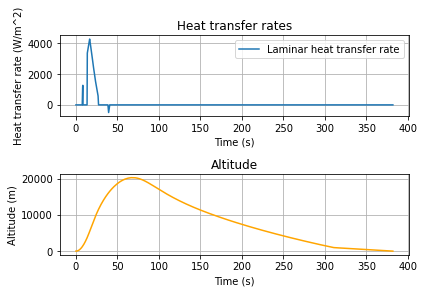

In [8]:
analysis.plot_heat_transfer_rates()